In [ ]:
ds# kullanılacak kütüphaneleri import ettik
import os
import cv2

import keras
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG19
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings("ignore")

Bu kısımda ise öncelikle verileri alacağımız path'i tanımladık. Daha sonra ise ImageDataGenerator yardımıyla fotoğrafları okurken ne şekilde okuyacağımızı seçtik. Daha sonra ise train ve test için ayırdığımız verileri okuduk. Bu veriler bizim train ve test klasörlerimizde bulunuyor. Batch_size'ı 16 olarak aldık. Okunacak fotoğrafların boyutu ise 224x224 olacak. Train klasöründe topllam 229 tane veri var. Test klasöründe toplam 24 tane veri var.

In [ ]:
path = "/content/drive/MyDrive/Proje/brain_tumor_dataset/"

image_generator = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2, 
    validation_split=0.1)    

training_set = image_generator.flow_from_directory(batch_size=16,
                                                 directory=path + "train",
                                                 shuffle=True,
                                                 target_size=(224,224), 
                                                 color_mode='rgb',
                                                 class_mode='binary')

testing_set = image_generator.flow_from_directory(batch_size=16,
                                                 directory=path + "test",
                                                 shuffle=True,
                                                 target_size=(224,224), 
                                                 color_mode='rgb',
                                                 class_mode='binary')

Found 229 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


Tümörlü ve tümörsüz olmak üzere iki farklı klasördeki verileri gösterdik. Üstteki fotoğraf tümörlü, alttaki tümörsüzü temsil ediyor.

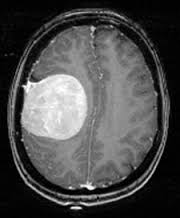

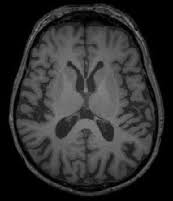

In [ ]:
img_yes = cv2.imread("/content/drive/MyDrive/Proje/brain_tumor_dataset/train/yes/Y1.jpg")
img_no = cv2.imread("/content/drive/MyDrive/Proje/brain_tumor_dataset/train/no/10 no.jpg")
cv2_imshow(img_yes)
cv2_imshow(img_no)

Burada ise keras kütüphanesinde hazır model olarak bulunan  VGG19 modelini tanımladık. Fotoğrafların girdisi olarak 224x224x3 olarak seçtik.

In [ ]:
model = VGG19(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )

80150528/80134624 [==============================] - 2s 0us/step


Burada ise tanımlanan VGG19 modelinin üzerine Flatten(düzleştirme) işlemi daha sonra dropout işlemi ve en sonda ise çıktı katmanı olan tek nöronluk bir dense katmanı tanımladık. Dense katmanının aktivasyon fonksiyonunu ise binary classification'da iyi sonuç veren sigmoid fonksiyonunu kullandık. En sonda ise modeli, "adam" optimizerı kullanarak ve "accuracy" metriğini kullanarak eğiteceğimizi belirttik. Summary kısmında modelin yapısını görebiliriz.

In [ ]:
x = Flatten()(model.output)
x = Dropout(0.4)(x)
x = Dense(1, activation = "sigmoid")(x)

model = keras.Model(model.input, x)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Eğitim işlemini başlattık. Train için train klasöründeki verileri, validation için ise test klasöründeki verileri kullandık. 60 epoch kullanarak bir model eğittik.

In [ ]:
hist = model.fit_generator(training_set,validation_data = testing_set, epochs = 60)

Epoch 1/60
15/15 [==============================] - 194s 12s/step - loss: 0.6757 - accuracy: 0.6856 - val_loss: 0.4282 - val_accuracy: 0.8333
Epoch 2/60
15/15 [==============================] - 159s 11s/step - loss: 0.4549 - accuracy: 0.8166 - val_loss: 0.8300 - val_accuracy: 0.7083
Epoch 3/60
15/15 [==============================] - 161s 11s/step - loss: 0.4341 - accuracy: 0.8079 - val_loss: 0.5668 - val_accuracy: 0.7083
Epoch 4/60
15/15 [==============================] - 158s 11s/step - loss: 0.3543 - accuracy: 0.8603 - val_loss: 0.3496 - val_accuracy: 0.7917
Epoch 5/60
15/15 [==============================] - 160s 11s/step - loss: 0.2947 - accuracy: 0.8777 - val_loss: 0.4298 - val_accuracy: 0.8333
Epoch 6/60
15/15 [==============================] - 158s 11s/step - loss: 0.2601 - accuracy: 0.9039 - val_loss: 0.5513 - val_accuracy: 0.7083
Epoch 7/60
15/15 [==============================] - 158s 11s/step - loss: 0.2576 - accuracy: 0.8952 - val_loss: 0.4771 - val_accuracy: 0.7500
Epoch 

Eğitim işlemi bittikten sonra yukarıda gösterdiğimiz ve tümör bulunan veri üzerinden bir tahmin (prediction) işlemi gerçekleştirdik. Model bu tahmin işlemini doğru bir şekilde gerçekleştirdi.

In [ ]:
img_yes = cv2.resize(img_yes, (224, 224))
img_yes = img_yes.reshape(1, 224, 224, 3)
tahmin = model.predict(img_yes)

In [ ]:
tahmin[0][0]

1.0

Eğitilen modelimizin doğruluk (accuracy) ve kayıp (loss) değerlerini bulduk. %83'lük bir doğruluk oranına sahip bir modelimiz var. Bu iyi bir sonuç. Bu sonucu farklı model kullanarak, farklı parametreler kullanarak, veri seti arttırarak vb. yollarla arttırabiliriz.

In [ ]:
loss, acc = model.evaluate_generator(testing_set, 24//1, verbose=1)
print("Accuracy = ", acc ," - loss = ", loss)

24/24 [==============================] - 16s 217ms/step - loss: 0.2585 - accuracy: 0.8333
Accuracy =  0.8333333134651184  - loss =  0.2584576904773712


Modelimizi kaydettik. Bu sayede test yapmak için her seferinde yeni model eğitmeden bu modeli yükleyerek test yapabiliriz.

In [ ]:
model.save(path + "brain_tumor.h5")

Test klasöründe bulunan veriler üzerinden tahmin işlemini gerçekleştirdik ve opencv kütüphanesi yardımıyla bu görüntüleri okuduk. Tahmin edilen (yes, no) değerlerini fotoğrafın sağ alt köşesine, gerçekte olan değerleri ise metnin sol alt köşesine yazdırdık.

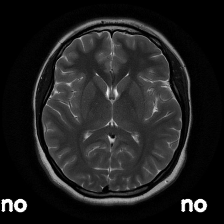

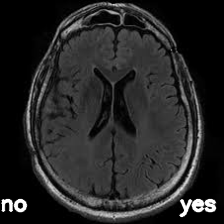

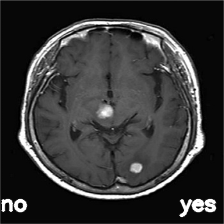

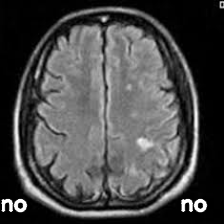

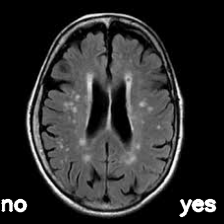

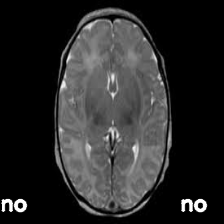

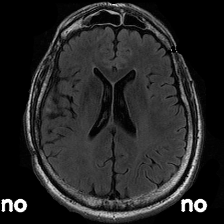

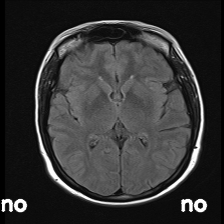

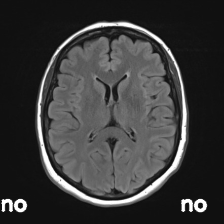

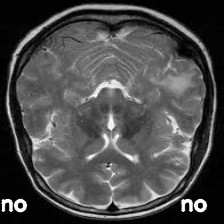

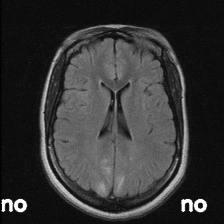

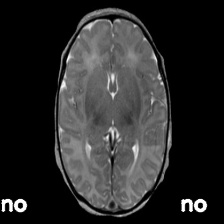

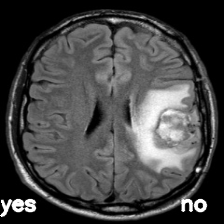

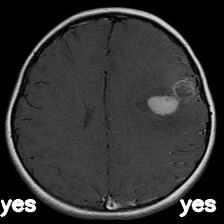

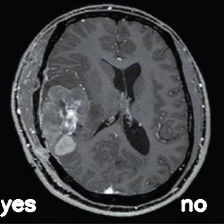

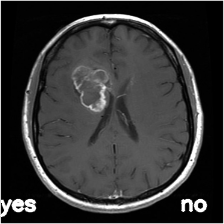

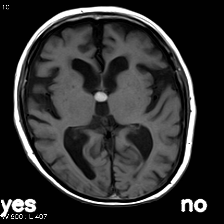

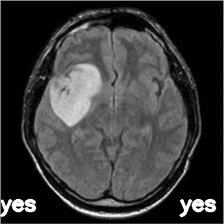

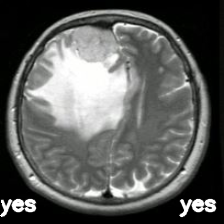

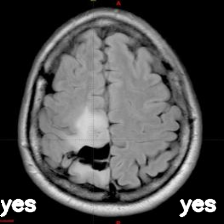

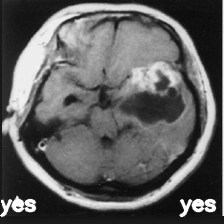

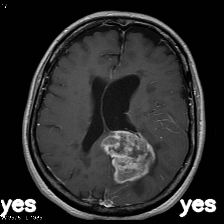

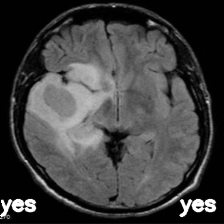

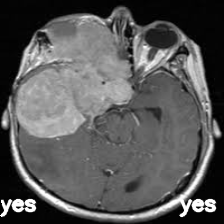

In [ ]:
path_test, count = path + "test/", 1
for i in os.listdir(path_test):
  for j in os.listdir(path_test + i):
    img = cv2.imread(path + i + "/" + j)
    img = cv2.resize(img, (224, 224))
    img_pred = img.reshape(1, 224, 224, 3)
    tahmin_sonucu = model.predict(img_pred)[0][0]
    if tahmin_sonucu == 1.0:
      foto_metin_tahmin = "yes"
    else:
      foto_metin_tahmin = "no"
    
    if count < 13:
      foto_metin_actual = "no"
    else:
      foto_metin_actual = "yes"
    cv2.putText(img, foto_metin_tahmin, (180, 210), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(img, foto_metin_actual, (0, 210), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    cv2_imshow(img)
    count += 1